Расмотрим пример на датасете из репозитория UCI

Описание данных - https://archive.ics.uci.edu/ml/datasets/banknote+authentication#

In [4]:
import pandas as pd
import numpy as np
data = pd.read_csv("data_banknote_authentication.txt", header=None)
data.head(3)

,0,1,2,3,4
0,3.6216,8.6661,-2.8073,-0.44699,0
1,4.5459,8.1674,-2.4586,-1.46210,0
2,3.8660,-2.6383,1.9242,0.10645,0


У нас есть 4 признака и 1 целевая переменная (бинарная) - нужно определить поддельная купюра или нет

In [5]:
print(data.shape)

(1372, 5)


Всего 1372 купюры

Посмотрим на соотношение классов

In [3]:
data.iloc[:, -1].value_counts()

0    762
1    610
Name: 4, dtype: int64

Разбиваем выборку на тренировочную и тестовую части и обучаем модель (в примере - градиентный бустинг)

In [6]:
from sklearn.model_selection import train_test_split

x_data = data.iloc[:,:-1]
y_data = data.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=7)

In [7]:
import xgboost as xgb

model = xgb.XGBClassifier()

model.fit(x_train, y_train)
y_predict = model.predict(x_test)

/Users/artemzraev/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Проверяем качество

In [8]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 

    
evaluate_results(y_test, y_predict)

Classification results:
f1: 99.57%
roc: 99.57%
recall: 99.15%
precision: 100.00%


### Теперь очередь за PU learning

Представим, что нам неизвестны негативы и часть позитивов

In [9]:
mod_data = data.copy()
#get the indices of the positives samples
pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
#shuffle them
np.random.shuffle(pos_ind)
# leave just 25% of the positives marked
pos_sample_len = int(np.ceil(0.25 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 153/610 as positives and unlabeling the rest


Создаем столбец для новой целевой переменной, где у нас два класса - P (1) и U (-1)

In [10]:
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    1219
 1     153
Name: class_test, dtype: int64


* We now have just 153 positive samples labeled as 1 in the 'class_test' col while the rest is unlabeled as -1.

* Recall that col 4 still holds the actual label

In [11]:
mod_data.head(10)

,0,1,2,3,4,class_test
0,3.62160,8.6661,-2.80730,-0.44699,0,-1
1,4.54590,8.1674,-2.45860,-1.46210,0,-1
2,3.86600,-2.6383,1.92420,0.10645,0,-1
3,3.45660,9.5228,-4.01120,-3.59440,0,-1
4,0.32924,-4.4552,4.57180,-0.98880,0,-1
5,4.36840,9.6718,-3.96060,-3.16250,0,-1
6,3.59120,3.0129,0.72888,0.56421,0,-1
7,2.09220,-6.8100,8.46360,-0.60216,0,-1
8,3.20320,5.7588,-0.75345,-0.61251,0,-1
9,1.53560,9.1772,-2.27180,-0.73535,0,-1


Remember that this data frame (x_data) includes the former target variable that we keep here just to compare the results

[:-2] is the original class label for positive and negative data [:-1] is the new class for positive and unlabeled data

In [12]:
x_data = mod_data.iloc[:,:-2].values # just the X 
y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
y_positive = mod_data.iloc[:,-2].values # original class

### 1. random negative sampling

In [13]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(153, 6) (153, 6)


In [14]:
model = xgb.XGBClassifier()

model.fit(sample_train.iloc[:,:-2].values, 
          sample_train.iloc[:,-2].values)
y_predict = model.predict(sample_test.iloc[:,:-2].values)
evaluate_results(sample_test.iloc[:,-2].values, y_predict)

Classification results:
f1: 97.73%
roc: 98.51%
recall: 99.23%
precision: 96.28%


### Домашнее задание

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
6. применить random negative sampling для построения классификатора в новых условиях
7. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
8. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

<b>Бонусный вопрос:</b>

Как вы думаете, какой из методов на практике является более предпочтительным: random negative sampling или 2-step approach?

Ваш ответ здесь:

In [ ]:
Домашнее задание №6

Набор данных https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+#

данные, используемые для бинарной классификации (заполняемость комнаты) по температуре, влажности, освещенности и CO2.

In [4]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [6]:
df = pd.read_csv("datatraining.txt")
df.head(3)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1


In [7]:
df.shape

(8143, 7)

Всего 8143 наблюдения. 5 столбцов для анализа, бинарная целевая переменная Occupancy.

Столбец date - метка времени, которая выступает в качестве ID для данных.он не нужен, можем убрать этот столбец.

In [8]:
df = df.drop(['date'], axis=1)

Посмотрим на соотношение классов

In [9]:
df.iloc[:, -1].value_counts()

0    6414
1    1729
Name: Occupancy, dtype: int64

Проверяем наличие пропусков

In [10]:
df.notnull().sum()

Temperature      8143
Humidity         8143
Light            8143
CO2              8143
HumidityRatio    8143
Occupancy        8143
dtype: int64

In [11]:
df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863,0.212330
std,1.016916,5.531211,194.755805,314.320877,0.000852,0.408982
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,19.700000,20.200000,0.000000,439.000000,0.003078,0.000000
50%,20.390000,26.222500,0.000000,453.500000,0.003801,0.000000
75%,21.390000,30.533333,256.375000,638.833333,0.004352,0.000000
max,23.180000,39.117500,1546.333333,2028.500000,0.006476,1.000000


Признаки Temperature, Humidity и HumidityRatio не требуют дополнительной обработки

<AxesSubplot:ylabel='Frequency'>

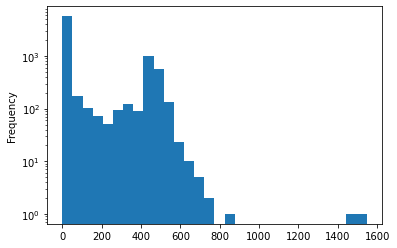

In [12]:
df.Light.plot.hist(bins=30, log=True)

In [13]:
df.loc[df['Light']> 1000, 'Light'] = df.loc[df['Light']< 1000, 'Light'].median()

<AxesSubplot:ylabel='Frequency'>

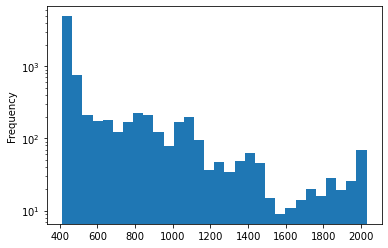

In [14]:
df.CO2.plot.hist(bins=30, log=True)

In [15]:
correlation = df.corr()
corr_with_target = correlation["Occupancy"].sort_values(ascending = False)
corr_with_target

Occupancy        1.000000
Light            0.913949
CO2              0.712235
Temperature      0.538220
HumidityRatio    0.300282
Humidity         0.132964
Name: Occupancy, dtype: float64

Освещенность и CO2 сильно скоррелированы с целевой переменной.

Разбиваем выборку на тренировочную и тестовую части и обучаем модель

In [16]:
from sklearn.model_selection import train_test_split

x_data = df.iloc[:,:-1]
y_data = df.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=7)

In [17]:
import xgboost as xgb

model = xgb.XGBClassifier()

model.fit(x_train, y_train)
y_predict = model.predict(x_test)

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:31:51] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Проверяем качество

In [18]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

def evaluate_results(y_test, y_predict):
    
    f1 = f1_score(y_test, y_predict)
    
    roc = roc_auc_score(y_test, y_predict)
    
    rec = recall_score(y_test, y_predict, average='binary')
    
    prc = precision_score(y_test, y_predict, average='binary')
    
    return [f1, roc, rec, prc]

    
classification = evaluate_results(y_test, y_predict)

In [19]:
classification

[0.9754838709677419,
 0.9843463281279256,
 0.9767441860465116,
 0.9742268041237113]

PU learning
Представим, что нам неизвестны негативы и часть позитивов

In [20]:
mod_data = df.copy()

#сохраняем индексы позитивных значений
pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]

# Перемешиваем их
np.random.shuffle(pos_ind)

# Оставляем 25% данных, коорые промаркированы позитивами
pos_sample_len = int(np.ceil(0.25 * len(pos_ind)))
print(f'Используем {pos_sample_len} из {len(pos_ind)} как позитивные значения, остальные будут "без маркировки"')
pos_sample = pos_ind[:pos_sample_len]

Используем 433 из 1729 как позитивные значения, остальные будут "без маркировки"


Создаем столбец для новой целевой переменной, где у нас два класса - P (1) и U (-1)

In [21]:
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    7710
 1     433
Name: class_test, dtype: int64


Теперь у нас 433 наблюдения с меткой 1, остальные промаркированы как -1

Проверим, что датасет все еще содержит настоящие метки (столбец Occupancy)

In [22]:
mod_data.head(3)

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,class_test
1,23.18,27.2720,426.0,721.25,0.004793,1,-1
2,23.15,27.2675,429.5,714.00,0.004783,1,-1
3,23.15,27.2450,426.0,713.50,0.004779,1,-1


In [23]:
x_data = mod_data.iloc[:,:-2].values # Признаки для анализа (без Occupancy и class_test)
y_labeled = mod_data.iloc[:,-1].values # новый класс (P & U) - class_test
y_positive = mod_data.iloc[:,-2].values # оригинальные метки - Occupancy

Random negative sampling

In [24]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(433, 7) (433, 7)


In [25]:
model = xgb.XGBClassifier()

model.fit(sample_train.iloc[:,:-2].values, 
          sample_train.iloc[:,-2].values)
y_predict = model.predict(sample_test.iloc[:,:-2].values)
PU_learning = evaluate_results(sample_test.iloc[:,-2].values, y_predict)

[20:36:31] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [26]:
table = pd.DataFrame(data= {'Results': ['f1', 'roc', 'recall', 'precision'],
                            'Classification': classification,
                            'PU learning': PU_learning}
                    )
table

,Results,Classification,PU learning
0,f1,0.975484,0.961216
1,roc,0.984346,0.983862
2,recall,0.976744,0.979625
3,precision,0.974227,0.943485
